In [2]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import scipy as scp
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq
import cairosvg
from PIL import Image


In [3]:
# For plotting, from Luke

def compute_bounds(mu, sig, n_sigma = 3):
    """
    Use mean and standard deviation vectors to compute upper and lower bounds.
    """
    upper = mu + n_sigma * np.sqrt(np.abs(sig))
    lower = mu - n_sigma * np.sqrt(np.abs(sig))
    
    return upper, lower

In [8]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/FigS04_def.hdf5", "r")

#get the data for plotting the sd image
dataCh0 = np.array(f1['dataCh0'])
ls_roimask = np.array(f1['ls_roimask'])
ls_x_zoom = np.array(f1['ls_x_zoom'])
noise_roimask = np.array(f1['noise_roimask'])
noise_x_zoom = np.array(f1['noise_x_zoom'])
dataCh0_noise = np.array(f1['dataCh0_noise'])

f1.close()

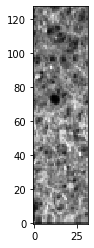

In [9]:
#calculate std for the motion responses
ls_std = np.std(dataCh0, axis=2)  # standard deviation across time
ls_avg_projection = np.mean(dataCh0, axis=2)

plt.imshow(ls_avg_projection[:,:], cmap='Greys_r', origin='lower')

# Figpath = 'Fig_temp/'
# savename = Figpath+"LongShort_SD_image_fieldB.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

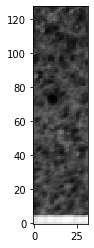

In [10]:
#calculate std
noise_std = np.std(dataCh0_noise, axis=2)  # standard deviation across time
noise_avg_projection = np.mean(dataCh0_noise, axis=2)

plt.imshow(noise_avg_projection[:,:], cmap='Greys_r', origin='lower')

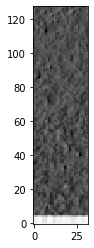

In [11]:
plt.imshow(noise_avg_projection-ls_avg_projection, cmap='Greys_r', origin='lower')

In [12]:
import scipy.signal

def cross_image(im1, im2):
    # get rid of the averages, otherwise the results are not good
    im1_gray = im1 - np.mean(im1)
    im2_gray = im2 - np.mean(im2)

    # calculate the correlation image; note the flipping of one of the images
    return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

In [13]:
corr_img_ftt = cross_image(noise_avg_projection[4:,:], ls_avg_projection[4:,:])
corr_img_ftt_test = cross_image(noise_avg_projection[4:,:], noise_avg_projection[4:,:])
ind = np.unravel_index(np.argmax(corr_img_ftt, axis=None), corr_img_ftt.shape)
ind_test = np.unravel_index(np.argmax(corr_img_ftt_test, axis=None), corr_img_ftt_test.shape)

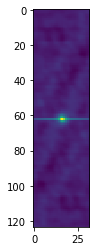

In [14]:
plt.imshow(corr_img_ftt_test)

((62, 15), (62, 16))

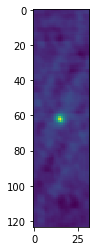

In [15]:
plt.imshow(corr_img_ftt)
ind, ind_test

In [16]:
shift = np.array(ind) - np.array(ind_test)
x_shift = shift[1]
y_shift = shift[0]

x_shift, y_shift

(-1, 0)

# If shifting run this section (this one doesn't need to be shifted)

In [17]:
# #not working because the shift is negative and zero
# corr_fixed_x = cross_image(noise_avg_projection[4-(x_shift):,-y_shift:], ls_avg_projection[4:,:]) #ls_avg_projection[4:-y_shift,:-x_shift]
# ind_fixed_x = np.unravel_index(np.argmax(corr_fixed_x, axis=None), corr_fixed_x.shape)

# ind_fixed_x

In [18]:
# shifty = np.array(ind_fixed_x) - np.array(ind_test)
# x_shifty = shifty[1]
# y_shifty = shifty[0]

# x_shifty, y_shifty

In [19]:
# corr_fixed_xy = cross_image(noise_avg_projection[4:,:], ls_avg_projection[4:-(y_shifty+y_shift),:-(x_shifty+x_shift)])
# ind_fixed_xy = np.unravel_index(np.argmax(corr_fixed_xy, axis=None), corr_fixed_xy.shape)

# ind_fixed_xy

In [20]:
# plt.imshow(corr_fixed_x)

In [21]:
# plt.imshow(noise_avg_projection[4:,:])

In [22]:
# plt.imshow(ls_avg_projection[4:-(y_shifty+y_shift),:-(x_shifty+x_shift)])

# Get the common ROIs

In [26]:
#pull this data from the hdf5 file
noise_pixels = pd.read_hdf('Data/FigS04_def.hdf5', 'noise_pixels')
motion_pixels = pd.read_hdf('Data/FigS04_def.hdf5', 'motion_pixels')

pixel_lists = noise_pixels['pixel_lists'].values
center_px_ids = noise_pixels['center_px_ids'].values

roi_lists_ls = motion_pixels['roi_list'].values
center_px_ls = motion_pixels['center_pixel_id'].values

In [27]:
# find the x and y coordinates of pixels in the noise group and check for matches
threshold_count = 4


dsmap0 = noise_roimask*(-1)*1000
xlength = dsmap0.shape[0]
ylength = dsmap0.shape[1]


center_px_for_noise = [] # gives the center pixel ids that have a possible match
gp_pixel_lists = [] # gives a list of pixels that has a possible match

for i, pixel_list in enumerate(pixel_lists): #take each noise pixel list
    x_list = []
    y_list = []

    for x in range(xlength):
        for y in range(ylength):  
            if dsmap0[x,y]/1000 in pixel_list:
    #             print(x,y)
                x_list.append(x) #make list of x and y coordinates of each pixel
                y_list.append(y)

    x_list_shifted = np.array(x_list) #- (y_shift + y_shifty)

    y_list_shifted = np.array(y_list) #- (x_shift + x_shifty)

    count = 0
    gp_pixel_group = []
    for j, x in enumerate(x_list_shifted):
        y = y_list_shifted[j]
    #     print(ls_roimask[x, y])
        if ls_roimask[x, y]<0:
            count+=1
            #get the pixel in gp that corresponds to the pixel in noise
            gp_pixel_group.append(ls_roimask[x, y]*-1) 
    
    #
    if count>threshold_count:
        center_px_for_noise.append(center_px_ids[i]) # this is not right
        gp_pixel_lists.append(gp_pixel_group)

In [28]:
#find the matches in the noise and motion
matches = []
center_pixels_gp = []
center_pixels_noise = []

for i, roi_list in enumerate(roi_lists_ls):
    if roi_list in gp_pixel_lists:
#         print(i)
        matches.append(roi_list)
        center_pixels_gp.append(center_px_ls[i])
        noise_index = gp_pixel_lists.index(roi_list)
        center_pixels_noise.append(center_px_for_noise[noise_index])


# Plot the spline and GP for a single ROI

In [32]:
#pull this data from the hdf5 file
noise_spline_all = pd.read_hdf('Data/FigS04_def.hdf5', 'noise_spline_all')
gp_results_all = pd.read_hdf('Data/FigS04_def.hdf5', 'gp_results_all')
results_ds = pd.read_hdf('Data/FigS04_def.hdf5', 'results_ds')

In [33]:
i = 151#160 (good), 52 (outside stim region), 180 (additional example near end of field), 151 (just outside stim)
noisepx = center_pixels_noise[i]
gppx = center_pixels_gp[i]

gp_results_roi = gp_results_all.loc[gp_results_all['center_pixel_id']==gppx]

In [34]:
mu = gp_results_roi['mu'].values[0]
x_predict = gp_results_roi['x_predict'].values[0]
sig = gp_results_roi['sig'].values[0]
sig_outer = gp_results_roi['sig_outer'].values[0]
x_predict_t = np.copy(x_predict[::mu.shape[0],:])

In [37]:
#get the data for scaling
data_df = pd.read_hdf('Data/FigS04_def.hdf5', 'data_df')

In [38]:
#get GP info
results_ds_roi = results_ds.loc[results_ds['center_pixel_id']==gppx]
d_prime = results_ds_roi['d_prime'].values[0]

rois = gp_results_roi['roi_list'].values[0]

#get the average response of these rois (averaged over binned time of the traces) that was used for GP modeling

df_GP_rois = data_df.loc[rois].groupby(
    ['directions', 'lengths', 'trial_nums', 'time_resampled']).mean()

df_GP_rois = df_GP_rois.reset_index()
df_GP_rois = df_GP_rois.set_index(['directions', 'lengths', 'time_bin'])

df_GP_rois_average = df_GP_rois.groupby(['directions', 'lengths', 'time_bin']).mean()

mean_of_trace = df_GP_rois['y'].mean()
sd_of_trace = df_GP_rois['y'].std()

<Figure size 1080x432 with 0 Axes>

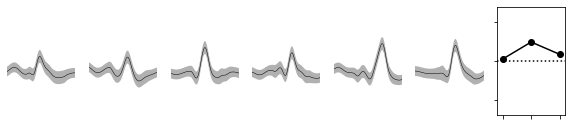

In [39]:
#plot gp preditions
plt.figure(figsize=(15, 6))
directions = [0, 180]
lengths = [100, 150, 300]

colors1 = ['peru', 'lightseagreen', 'peru', 'lightseagreen', 'peru', 'lightseagreen']
colors2 = ['blue', 'black', 'green', 'magenta', 'purple', 'orange']
# colors3 = cm.get_cmap('Dark2')

n_conditions = mu.shape[0]
# gp_index = [0, 2, 1, 3, 5, 4]
gp_index = [3, 0, 5, 2, 4, 1]

plt.figure(figsize=(10, 2))
# plt.title(str(d_prime))
color = 2#color_id/(7)
index = 1
for length in lengths:
    for direction in directions:

        ax1 = plt.subplot(1,7,index)
        upper, lower = compute_bounds(mu[gp_index[index-1],:]/sd_of_trace, sig[gp_index[index-1],:]/sd_of_trace, n_sigma = 3, )
        plt.fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3, )
        plt.plot(x_predict_t[:,0], mu[gp_index[index-1],:]/sd_of_trace, color='k', label=str(direction)+', '+str(length), lw=0.5)
        
        plt.axis('off')
        axes = plt.gca()
        axes.set_xlim([0.5, 2.])
        axes.set_ylim([-2, 3])

        index+=1

ax1 = plt.subplot(1,7,7)    
lengths = ['100', '150', '300']

plt.plot(lengths, d_prime*-1, color='k', marker='o')

axes = plt.gca()
axes.set_ylim([-70,70])
axes.set_xlim([-0.2,2.2])
axes.axhline(linestyle='dotted', color='k')
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])


# Figpath = 'Fig_temp/'
# savename = Figpath+"X_fieldB_gp_example_"+str(i)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
        
plt.show()

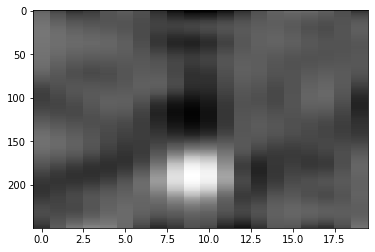

In [40]:
#plot the spline fit for this ROI
noise_spline_roi = noise_spline_all.loc[noise_spline_all['center_pixel_id']==noisepx]

noise_spline = noise_spline_roi['spl'].values[0]

plt.imshow(noise_spline, aspect='auto', cmap='Greys_r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Noise_spline_example_"+str(i)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Single ROI Convolution

In [41]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion
#     print(stimulation_time, stimulation_time_pixel)
    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start
    
    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [44]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/FigS04_def.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']

In [45]:
# Get response predictions for 500 um/s for display
distances = [120, 170, 320]
responses = []
stimulus_images = []

for dist_cov in distances:
    

    convolution_params['stimulus_velocity'] = 500 # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 400 #need to change this to cover the whole trajectory
    convolution_params['distance_covered'] = dist_cov
    convolution_params['starting_point'] = 300 - convolution_params['distance_covered']


    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"
    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)
    stimulus_image = np.array(Image.open(name_png).convert('L'))
    stimulus_images.append(stimulus_image)

    
    # set up and crop the kernel
    spline = noise_spline
    edge_buffer = 15
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    stimulus_images.append(stimulus_image_rev)
    kernel_type = 'full'
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus
    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-edge_buffer, :]
    # crop the kernel depending on the type of experiment
    if kernel_type == 'full':
        spline_cut = spline[edge_buffer:-edge_buffer,
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    
    
    #convolve!
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []
    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    responses.append(response)
    responses.append(response_rev)
    

    

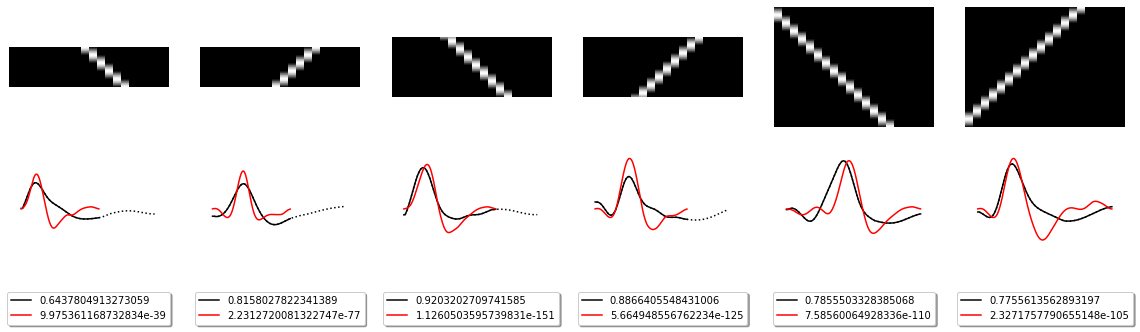

In [46]:
#plot the comparisons
fig, ax = plt.subplots(2, 6, figsize=(20, 5))
   

time_cut = 1.1 # aligning the beginning of the convolutions and GP predictions
dilation = 1.15 # adjusting the time scale manually to get better fits.  
yscale=1.5 #just for plotting
xscale1=1.0
xscale2=2.3

#scale all of them to the 300 out response size.
norm_factor = responses[4].max()#np.array([response.max() for response in responses]).max()
scale_factor = (mu[gp_index[4],:][np.where(x_predict_t[:,0]>time_cut)]/sd_of_trace).max()


for i in range(6):    
    
    response = responses[i]
    
    #plot results and calculate correlation
    #outward
    ax[0, i].imshow(stimulus_images[i], aspect=0.05, cmap='Greys_r')
    ax[0, i].set_axis_off()
    
    gp_x = x_predict_t[:,0][np.where(x_predict_t[:,0]>time_cut)]
    gp_y = mu[gp_index[i],:][np.where(x_predict_t[:,0]>time_cut)]/sd_of_trace
    ax[1, i].plot(gp_x, gp_y, color='k', linestyle='dotted')#, label="Motion Response (GP)")
    
    x_scale_pred = np.linspace(time_cut, 1+(response.shape[0]*2*dilation)/1000, (response.shape[0]))
    y_vals_pred = response*scale_factor/norm_factor
    
    
    start = x_scale_pred.min()
    stop = x_scale_pred.max()
    x = np.linspace(start, stop, num=response.shape[0]) 
    interp_gp = np.interp(x, gp_x, gp_y)
    gp_noise_corr = scipy.stats.pearsonr(list(interp_gp), list(y_vals_pred))
    
    
    ax[1, i].plot(x, interp_gp, color='k', label=str(gp_noise_corr[0]))
    ax[1, i].plot(x_scale_pred, y_vals_pred, color='r', label=str(gp_noise_corr[1]))#, label="Prediction from Convolution")
#     ax[1, i].legend()
    ax[1, i].set_ylim([-yscale,yscale])
    ax[1, i].set_xlim([xscale1,xscale2])
    
    # Shrink current axis's height by 10% on the bottom
    box = ax[1, i].get_position()
    ax[1, i].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    # Put a legend below current axis
    ax[1, i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=1)
    ax[1, i].set_axis_off()
    
# Figpath = 'Fig_temp/'
# i = 151
# savename = Figpath+"Convolution_GP_comparisons_"+str(i)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

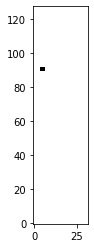

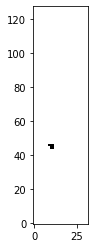

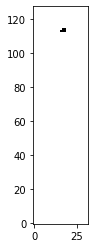

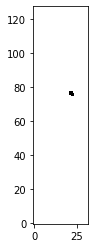

In [47]:
# find where this pixel is in the field and plot


#show where these pixels are

center_pixels = [1613, 779, 1874, 1424]#[1613 = index 160], [779 = 52 index ], [1874 = 180 index ], [1424 = index 151 ]
roi_list_all = []
for px in center_pixels:
#     window = 'center_pixel_id = {}'.format(str(px))  #examples in the box: 208, 316, 631, 916 #outside the box: 1304, 2009, 1536
#     results = (GaussianProcessBct() & ls_key & window).fetch1('roi_list')
    results_roi = gp_results_all.loc[gp_results_all['center_pixel_id']==px]
    pxlist = results_roi['roi_list'].values[0]
    roi_list_all.append(pxlist)


for i, rois in enumerate(roi_list_all):
    dsmap0 = ls_roimask*(-1)
    xlength = dsmap0.shape[0]
    ylength = dsmap0.shape[1]
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap0[x,y] in rois:
                dsmap0[x,y] = i+1
            elif dsmap0[x,y]>0:
                dsmap0[x,y] = np.nan
            else:
                dsmap0[x,y] = np.nan

    fig=plt.figure()
#     plt.imshow(dsmap0[:80,:], cmap='rainbow', origin='lower', vmin=1, vmax=8)
    plt.imshow(dsmap0, cmap='Greys', origin='lower', vmin=0, vmax=1)

#     Figpath = 'Fig_temp/'
#     savename = Figpath+"X_fieldB_roimap_"+str(center_pixels[i])+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')
